# Lab Model order selection

The goal of this lab session is to study different model order selection methods. You will send only one notebook for both parts.

You have to send the filled notebook named **"MOS_familyname1_familyname2.ipynb"** (groups of 2) by email to *lucca.guardiola@centralesupelec.fr* by November 26, 2020 and put **"AML-MOS"** in the subject. 

We begin with the standard imports:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## Theoretical questions 

What is the expression of the AIC and BIC for a dataset $\{X_1,...X_n \}$ modeled with a GMM with $k$ mixtures after EM algorithm.

**Answer:**

For GMM, we have 2 unknown parameters per mixture: its mean and its standard deviation.

$$AIC = ln(p(X\mid \hat{\theta}_{ML})) - 2k$$

$$BIC = ln(p(X\mid \hat{\theta}_{ML})) - kn$$

Where $p$ represents the likelihood function for a GMM model:

$$ \prod_{i=1}^n \sum_{k=1}^K \pi_k \mathcal{N}(x_i;\mu_k, \sigma_k^2) $$

Where $\mathcal{N}$ is the probability distribution function for in a Gaussian distrubtion parametrized by $\mu$ and $\sigma^2$

What is the expression of the AIC and BIC for a dataset $\mathcal{X} =\{(X_1,Y_1),...(X_n,Y_n) \}$ modeled with a Logistic Regression after its training on $\mathcal{X}$. Suppose we have 2 labels and X has p features

**Answer:**

Since we have p features, we have p+1 (p features + bias) parameters to estimate.

$$AIC = ln(p(X\mid \hat{\theta}_{ML})) - (p+1)$$

$$BIC = ln(p(X\mid \hat{\theta}_{ML})) - \frac{(p+1)n}{2}$$

Where $p$ represents the likelihood function for a Logistic Regression model:
$$\prod_{i=1}^n \sigma (\theta^T x_i)^{y_i} – [1 - \sigma (\theta^T x_i)]^{(1 – y_i)}$$

Explain briefly the concept of K-fold cross validation. 

**Answer:** With K-fold cross-validation, we want to find the best model among a selection of models that would be the most generalizable, i.e. that is the least prone to overfitting.

For each model option, we split the data into a training and a validation set. We compute the performance score on the validation set. We repeat that K times. At the end, we get an average performance score for that specific option.

We repeat the process for each model options and in the end, we choose the model with the best average performance score.

## Application AIC/BIC

You are going apply the criterias on several datasets.

## Clustering

AIC and BIC can help to estimate the number of clusters when EM algorithm is used (because it's a probabilistic model.) 


In [4]:
from sklearn.datasets import load_wine
wine = load_wine()
X = wine.data
from sklearn.mixture import GaussianMixture

### Task : 
- Apply GaussianMixture model using different number of mixture. 
- Choose the number of mixtures with the BIC/AIC.

Use the .bic(X) and the .aic(X) method already implemented in sklearn

In [5]:
n_components = np.arange(10, 151, 10)
all_models = [GaussianMixture(n_components=n).fit(X) for n in n_components]
errors_aic = [model.aic(X) for model in all_models]
errors_bic = [model.bic(X) for model in all_models]

Text(0.5, 1.0, 'AIC values')

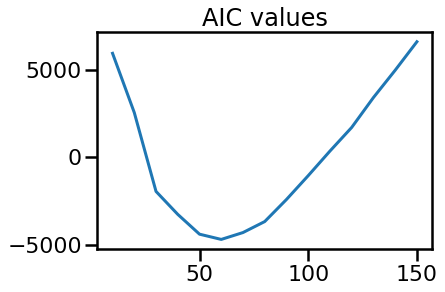

In [6]:
plt.plot(n_components, errors_aic)
plt.title("AIC values")

Text(0.5, 1.0, 'BIC values')

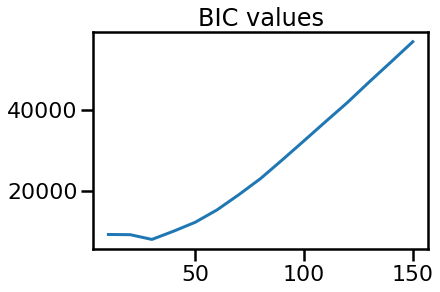

In [7]:
plt.plot(n_components, errors_bic)
plt.title("BIC values")

The AIC estimation is minimal at around 45-50 components for our mixture. Meanwhile, the BIC esimation is minimal in the range of 0-40 and then linearly increases. 

With this information, we can assume the minimal error is in the range of 40-50. Therefore, we can select the parameter of n to 45.

In [8]:
GMM = GaussianMixture(n_components=45).fit(X)

## Classification

### Tasks : 
- Train logistic regression model on the dataset
- Compute AIC for this dataset


In [10]:
from sklearn.datasets import load_wine
wine = load_wine()
X = wine.data
y = wine.target
from sklearn.linear_model import LogisticRegression

In [11]:
reg = LogisticRegression(max_iter=5000)

reg.fit(X, y)

LogisticRegression(max_iter=5000)

We recall that the AIC is defined by the log-likelihood of the model minus the number of parameters in our model.

The number of parameters is the easiest value to extract, we can simply count the coefficients in our Logistic Regression model. The scikit-learn way of doing this is using .coef_

Finally, for the log-likelihood of the model, we want to sum the likelihood for all of the correct labels in our model.

The function predict_log_proba is convenient for this, since it will return a N x K matrix with the log of the probability estimates, where N is our number of samples and K is the number of labels these samples can be assigned to.

Therefore, for any element N where the correct label was 2, we want to extract the value of predict_log_proba[N][2] for our sum while discarding all other predict_log_proba[N][x]. We can do this using a zip to get the values of the index, and then summing a list just the appropriate labels for each sample. Finally, by summing this list, we get the correct value.

In [12]:
ll_samples = [ll[index] for index, ll in zip(y, reg.predict_log_proba(X))]

total_ll = sum(ll_samples)

aic = total_ll - len(reg.coef_)

print(aic)

-9.432013875985124


### Does it seem to be reasonable to add a polynomial kernel as regards AIC or BIC ? 

By adding a polynomial kernel to our model, we will expand the dimensionality of our feature space. On one hand, this will allow for the model to have a larger amount of degrees of freedom, and thus, it will be able to achieve a better fit for all of the points in the data, therefore having a higher value of the likelihood function. This means that, over the entire dataset, the total log-likelihood function will increase in proportion to the degree of the polynomial features.

On the other hand, increasing the features will also increase the number of parameters in our model. Since this value is subtracted from our AIC value, that means that a higher degree polynomial will reduce the AIC.

Thus, we have the tradeoff that a higher order polynomial kernel will increase the log-likelihood part of AIC, while also increasing the penalization component of number of parameters. 

Then, we can see if it is reasonable or not by comparing the AIC values for with and without the kernel and choosing the one with higher AIC.  

If the kernel improves, the total LL will dominate the penalization, thus it is reasonable to add it. Otherwise, the kernel does not significantly improve the model, the penalization will be great and thus, the simpler model will have a greater AIC. On this case, adding polynomial features will not significatively improve our model and will risk overfitting.

Please note that some implementations might invert the equation for AIC, therefore we will look to minimize it, instead of maximizing it.

### What would the AIC be for LDA model assuming we have the same likelihood than the previous logistic regression ? 

Under LDA we establish a linear decision boundary that relies on multivariate Gaussian distribution for its construction. In LDA, the covariance matrices for these matrices are shared between all of the Gaussians.

Therefore, for a classification problem with K classes we have K gaussians (each one with a p x 1 mean vector and the same, pxp covariance matrix). Thus, our parameter space increases in the order of O(K * P)), together with the already considerable feature space of the covariance matrix (a little more than $\frac{p^2}{2} $, due to it being symmetric).

Under this function, the penalization factor of AIC will be very large, and will very often dominate the final AIC value. 

This means that even increasing slightly the value of P, the gain of accuracy in our model (represented under AIC by the log-likelihood) will still be dominated than the massive penalization that will be added. Thus, under a sufficiently large P, the likelihood will have little to no effect in the end value of the AIC. 

This implies that the AIC will no longer reliably evaluate a model's quality, and thus, is not recommended.

AIC/BIC and cross-validation are mostly used with linear Regression and logisitic regression. AIC/BIC rely on probabilistic caracterics of models in order to compute loglikelihood. 

Whereas crossvalidation can be applied in every models and give a more realistic vision of the performance of the model.


## Real Machine Learning situation

Imagine you want to develop and deploy for your job a machine learning algorithm capable of recognizing digits, in order to read automatically bank cheques or bills. 
The goal of the development phase for a data scientist is to choose the best performing model and also evaluate the most accurately the generalisation error on unseen data i.e the error the algorithm will produce when it will be operational. 
For instance in our case, an error from your algorithm will cost a certain amount of money, it's mandatory to estimate the potential financial loss induced by your model. 



In [1]:
from sklearn.datasets import load_digits
digits = load_digits()

X=digits.data
y=digits.target

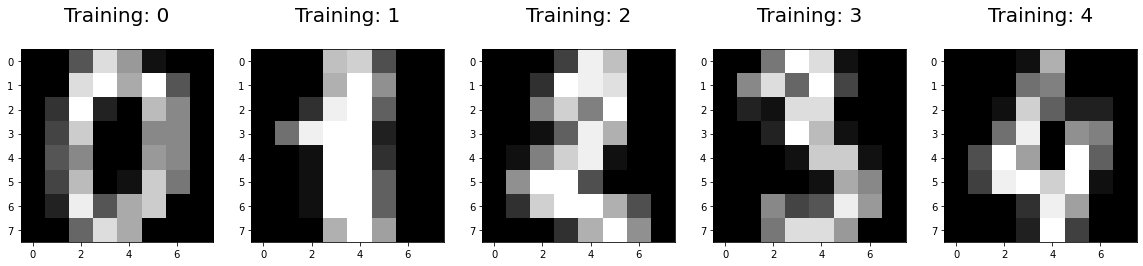

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

### Choose a model with Cross validation 
Cross validation provides a better estimation of the model's performance on the dataset than split train/test method. It's very useful for selecting the most accurate model. 


In [4]:
from sklearn.model_selection import cross_validate, train_test_split

### Tasks : 
- Apply cross validation to Logistic Regression and SVM, choose a C between 0.01 and 1 to add regularization
- Choose the best performing model

In [24]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

list_choices_c = np.arange(0.01,1,0.1)

# Logistic regression
print('')
print('Logistic regression')
list_scores_logreg = []
for c in list_choices_c:
    logreg = LogisticRegression(C=c)
    scores = cross_validate(logreg, preprocessing.scale(X), y, cv=5,scoring=('accuracy'))
    print('regularization:',c,'accuracy:',np.mean(scores['test_score']))
    list_scores_logreg.append(np.mean(scores['test_score']))
print('best c is',list_choices_c[np.argmax(list_scores_logreg)],'with score',np.max(list_scores_logreg))

# SVC
print('')
print('SVC')
list_scores_SVC = []
for c in list_choices_c:
    svm = SVC(C=c)
    scores = cross_validate(svm, X_train, y_train, cv=5,scoring=('accuracy'))
    print('regularization:',c,'accuracy:',np.mean(scores['test_score']))
    list_scores_SVC.append(np.mean(scores['test_score']))
print('best c is',list_choices_c[np.argmax(list_scores_SVC)],'with score',np.max(list_scores_SVC))


Logistic regression
regularization: 0.01 accuracy: 0.9170922315072734
regularization: 0.11 accuracy: 0.9265629835964099
regularization: 0.21000000000000002 accuracy: 0.9237836583101208
regularization: 0.31000000000000005 accuracy: 0.921558341070876
regularization: 0.41000000000000003 accuracy: 0.9204456824512535
regularization: 0.51 accuracy: 0.9198901268956978
regularization: 0.6100000000000001 accuracy: 0.9198901268956978
regularization: 0.7100000000000001 accuracy: 0.9198901268956978
regularization: 0.81 accuracy: 0.9198901268956978
regularization: 0.91 accuracy: 0.9193361188486536
best c is 0.11 with score 0.9265629835964099

SVC
regularization: 0.01 accuracy: 0.16631396957123099
regularization: 0.11 accuracy: 0.9476279391424619
regularization: 0.21000000000000002 accuracy: 0.9634301521438451
regularization: 0.31000000000000005 accuracy: 0.9667600276625172
regularization: 0.41000000000000003 accuracy: 0.9692565698478562
regularization: 0.51 accuracy: 0.9700899031811895
regularizat

Based on the results, we choose SVC with a C equal to 0.91 as it reaches a better score than logistic regression with any C values.

### Estimation of the generalization error

As we have choosen our model, we have to evaluate its future performance on unseen data. The most easy way is to use the split train/test method to have a confidence interval based on the performance of the model on the test dataset.

One could want to use cross validation for doing this estimation, however the several estimations returned by k fold cross-val don't garentee the independance of the estimations. The independence is needed for confidence intervals. This is why randomized split train/test is used.

### Tasks : 
- Split the dataset 50%/50% and fix the random state of the split_train_test
- Return the test accuracy with the choosen model

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50,random_state=42)

In [28]:
from sklearn.metrics import accuracy_score

best_model = SVC(C=0.91)
best_model.fit(X_train,y_train)
pred = best_model.predict(X_test)
p_hat = accuracy_score(y_test, pred)
p_hat

0.9721913236929922


### Confidence intervals
Assume that the event to have a right classification with our model follows a bernouilli process with paramater p. 
The accuracy on the test dataset ($\hat{p}$) gives us an estimation of p. 



### Task : Make a 99% interval of confidence of the real accuracy using Central limit theorem

In [32]:
value_z = 2.575829
lower_bound = p_hat-value_z*np.sqrt((p_hat*(1-p_hat))/len(y_test))
upper_bound = p_hat+value_z*np.sqrt((p_hat*(1-p_hat))/len(y_test))
print('confidence interval for p:[',lower_bound,'-',upper_bound,']')

confidence interval for p:[ 0.9580658437942476 - 0.9863168035917368 ]


### Hoeffding inequality 

A non negligeable inequality for constituting confidence interval for large dataset is Hoeffding inequality which is often tighter than CLT inequality for very large dataset (our dataset is maybe not large enough)

Hoeffding’s inequality: Suppose that $\{Z_1, . . . , Z_n\}$ are independent and that, $a ≤ Z_i ≤ b$, and $E[Z_i]=z$. Then for any $t>0$,

$$ P(|\hat{Z} - z|\ge t) \le \exp \left(-\frac{2nt^2}{(b-a)^2} \right)$$ 
With $\hat{Z} = \frac{1}{n} \sum_{i=1}^n Z_i $

Apply this inequality to the test accuracy $\hat{p}$ in order to have a 99% confidence interval


We can rewrite the inequality as follows:

$$ P(|\hat{Z} - z|\ge t) \le \exp \left(-\frac{2nt^2}{(b-a)^2} \right)$$ 

$$\iff P(\mid \hat{Z} - z \mid \geq t) \leq 2e^{-2nt^2}$$

$$\iff P(\mid \hat{Z} - z \mid < t) \geq 1-2e^{-2nt^2}$$

As we want a 99% confidence interval, we have $1-2e^{-2nt^2} = 0.99$.

Solving it for t gives:

$$1-2e^{-2nt^2} = 0.99$$

$$\iff -2e^{-2nt^2} = -0.01$$

$$\iff e^{-2nt^2} = 0.005$$

$$\iff -2nt^2 = log(0.005)$$

$$\iff t^2 = \frac{log(0.005)}{-2n}$$

$$\iff t = \sqrt{\frac{log(0.005)}{-2n}}$$

Thus, we have: $P(|\hat{Z} - z|\ge \sqrt{\frac{log(0.005)}{-2n}}) \le 0.99$

That leads to the following confidence interval:

$$P(\hat{Z} - \sqrt{\frac{log(0.005)}{-2n}} \leq z \leq \hat{Z} + \sqrt{\frac{log(0.005)}{-2n}}) \le 0.99$$

As a result, a 99% confidence interval for $p$ is:

$$\hat{p} \pm \sqrt{\frac{log(0.005)}{-2n}}$$

In [34]:
lower_bound = p_hat-np.sqrt(np.log(0.005)/(-2*len(y_test)))
upper_bound = p_hat+np.sqrt(np.log(0.005)/(-2*len(y_test)))
print('confidence interval for p:[',lower_bound,'-',upper_bound,']')

confidence interval for p:[ 0.9179070363497596 - 1.0264756110362248 ]
